In [1]:
#deal with tensors
import torch   

#handling text data
from torchtext.legacy import data

import matplotlib.pyplot as plt


In [2]:
#Reproducing same results
SEED = 10

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [3]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True, lower=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('label', LABEL), ('text',TEXT)]

/home/sergio/anaconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [4]:
#loading custom dataset
path = 'intent_data.csv'
training_data=data.TabularDataset(path = path, format = 'csv', fields = fields, skip_header = True)

#print preprocessed text
for i in range(200):
    print(vars(training_data.examples[i]))

{'label': 'ADD_INFO', 'text': ['i', 'love', 'museums']}
{'label': 'ADD_INFO', 'text': ['i', 'would', 'like', 'to', 'be', 'outside']}
{'label': 'ADD_INFO', 'text': ['i', 'love', 'to', 'be', 'outdoors']}
{'label': 'ADD_INFO', 'text': ['we', 'are', 'a', 'group']}
{'label': 'ADD_INFO', 'text': ['we', 'want', 'something', 'close']}
{'label': 'ADD_INFO', 'text': ['what', 'can', 'we', 'do', 'on', 'the', 'weekend']}
{'label': 'ADD_INFO', 'text': ['we', 'are', 'visiting', 'for', 'the', 'weekend']}
{'label': 'ADD_INFO', 'text': ['my', 'kids', 'are', 'hungry']}
{'label': 'ADD_INFO', 'text': ['we', 'are', 'tired']}
{'label': 'ADD_INFO', 'text': ['i', 'like', 'art']}
{'label': 'ADD_INFO', 'text': ['i', 'love', 'the', 'beach']}
{'label': 'ADD_INFO', 'text': ['we', 'want', 'to', 'try', 'local', 'cuisine']}
{'label': 'ADD_INFO', 'text': ['we', 'want', 'to', 'listen', 'to', 'music']}
{'label': 'ADD_INFO', 'text': ['is', 'there', 'live', 'music']}
{'label': 'ADD_INFO', 'text': ['i', 'want', 'to', 'try',

In [5]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

In [6]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=0,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 228
Size of LABEL vocabulary: 10
[('i', 50), ('do', 27), ('?', 26), ('to', 22), ('you', 19), ("n't", 18), ('we', 17), ('like', 17), ('want', 16), ('for', 15)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f2f7aa318b0>>, {'<unk>': 0, '<pad>': 1, 'i': 2, 'do': 3, '?': 4, 'to': 5, 'you': 6, "n't": 7, 'like': 8, 'we': 9, 'want': 10, 'for': 11, 'is': 12, 'it': 13, 'good': 14, 'that': 15, 'the': 16, 'there': 17, 'are': 18, 'my': 19, "'s": 20, 'a': 21, 'have': 22, 'here': 23, 'something': 24, '!': 25, 'any': 26, 'can': 27, 'museums': 28, 'not': 29, 'see': 30, 'what': 31, 'would': 32, 'great': 33, 'hello': 34, 'love': 35, 'museum': 36, 'thank': 37, 'yes': 38, "'m": 39, 'around': 40, 'bye': 41, 'children': 42, 'hi': 43, 'how': 44, 'later': 45, 'music': 46, 'no': 47, 'sure': 48, 'afternoon': 49, 'anything': 50, 'art': 51, 'be': 52, 'best': 53, 'course': 54, 'hate': 55, 'hermes': 56, 'looking': 57, 'loves': 58, 'of': 59, 

In [7]:
#check whether cuda is available
device = torch.device('cpu')  

#set batch size
BATCH_SIZE = 10

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [8]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Softmax()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [9]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 30
num_output_nodes = 10
num_layers = 1
bidirection = True
dropout = 0

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [10]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(228, 100)
  (lstm): LSTM(100, 30, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=60, out_features=10, bias=True)
  (act): Softmax(dim=None)
)
The model has 55,090 trainable parameters
torch.Size([228, 100])


In [11]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [12]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label.type(torch.LongTensor))        
    
        #compute the binary accuracy
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        
    return epoch_loss / len(iterator)

In [13]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [14]:
def evaluate_acc(model, iterator):
    correct_count = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            _, pred = torch.max(predictions, -1)
            correct_count += (pred == batch.label).sum()            
        
    return correct_count / len(valid_data), '%'



<ipython-input-8-9fce78094710>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs=self.act(dense_outputs)


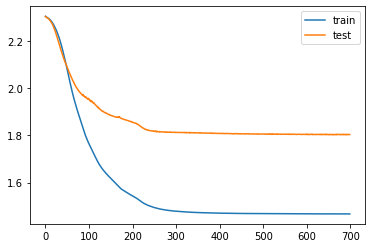

In [15]:
N_EPOCHS = 700
best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    train_loss_list.append(train_loss)
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    test_loss_list.append(valid_loss)
    
plt.plot(train_loss_list, label = 'train')
plt.plot(test_loss_list, label = 'test')
plt.legend()
plt.show()

In [16]:
evaluate_acc(model, valid_iterator)

<ipython-input-8-9fce78094710>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs=self.act(dense_outputs)


(tensor(0.6712), '%')

In [23]:
import time

time_0 = time.time()
#load weights
path='saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load("en_core_web_sm")

def predict(model, sentence):
    tokenized = [tok.text.lower() for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return 'Intent:' , list(LABEL.vocab.stoi)[torch.argmax(prediction)]


predict(model, "I don't like museums")
time_1 = time.time()
print('Total time spend =', time_1 - time_0)

Total time spend = 0.2787282466888428


<ipython-input-8-9fce78094710>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs=self.act(dense_outputs)


In [26]:
predict(model, "I like moder art")

<ipython-input-8-9fce78094710>:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs=self.act(dense_outputs)


('Intent:', 'ADD_INFO')

In [19]:
LABEL.vocab.stoi

defaultdict(None,
            {'CONFIRM': 0,
             'ADD_INFO': 1,
             'RECOMMENDATION': 2,
             'GREETING': 3,
             'ADD_INFO_NEG': 4,
             'REJECT': 5,
             'REQUEST_INFO': 6,
             'ADD_INFO_POS': 7,
             'THANKS': 8,
             'GOODBYE': 9})